### Import Libraries

In [1]:
import pandas as pd, json,os,openai
from langchain.callbacks import StdOutCallbackHandler
from langchain.schema import LLMResult, SystemMessage, AgentAction, AgentFinish, AIMessage, BaseMessage
from langchain.tools.python.tool import PythonAstREPLTool
from langchain.agents import Tool
from langchain.agents.openai_functions_agent.base import OpenAIFunctionsAgent, _format_intermediate_steps,  _FunctionsAgentAction

from langchain.callbacks.manager import Callbacks
from typing import Any, List, Tuple, Union, Dict,Optional
from json import JSONDecodeError
from langchain.agents import initialize_agent, AgentType,AgentExecutor, Tool, ZeroShotAgent, load_tools, BaseSingleActionAgent
from langchain.agents.chat.base import ChatAgent
from langchain.agents.chat.output_parser import ChatOutputParser
from langchain.agents.agent import AgentExecutor
from langchain.callbacks.base import BaseCallbackManager
from langchain.prompts.base import BasePromptTemplate
from langchain.base_language import BaseLanguageModel
from langchain import LLMChain, OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.agents.agent_types import AgentType
from langchain.llms import OpenAI

from pandas_profiling import ProfileReport
from dotenv import load_dotenv, find_dotenv
import matplotlib,langchain
from IPython.display import display, Markdown
%matplotlib inline

/var/folders/px/2j7rbmvj5fxf29t__gbwgvlm0000gp/T/ipykernel_74403/1154440450.py:23: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


### Import Data

In [2]:
# Load the survey questions file
with open('/Users/keshavkumar/Downloads/Knit/Knit-Project/survey_question_1_corrected.json', 'r') as f:
    survey_questions_data = json.load(f)

# Load the survey responses file
with open('/Users/keshavkumar/Downloads/Knit/Knit-Project/survey_response_1_corrected.json', 'r') as f:
    survey_responses_data = json.load(f)
null=None

### Custom Python-REPL and OpenAI Functions Agent

In [3]:
class CustomPythonAstREPLTool(PythonAstREPLTool):
    name = "python"
    description = (
        "A Python shell. Use this to execute python commands. "
        "The input must be an object as follows: "
        "{'__arg1': 'a valid python command.'}  "
        "When using this tool, sometimes output is abbreviated - "
        "Make sure it does not look abbreviated before using it in your answer. "
        "Don't add comments to your python code."
    )

def _parse_ai_message(message: BaseMessage) -> Union[AgentAction, AgentFinish]:
    """Parse an AI message."""
    if not isinstance(message, AIMessage):
        raise TypeError(f"Expected an AI message got {type(message)}")

    function_call = message.additional_kwargs.get("function_call", {})

    if function_call:
        function_call = message.additional_kwargs["function_call"]
        function_name = function_call["name"]
        try:
            _tool_input = json.loads(function_call["arguments"])
        except JSONDecodeError:
            # print(
            #     f"Could not parse tool input: {function_call} because "
            #     f"the `arguments` is not valid JSON."
            # )
            _tool_input = function_call["arguments"]

        # HACK HACK HACK:
        # The code that encodes tool input into Open AI uses a special variable
        # name called `__arg1` to handle old style tools that do not expose a
        # schema and expect a single string argument as an input.
        # We unpack the argument here if it exists.
        # Open AI does not support passing in a JSON array as an argument.
        if "__arg1" in _tool_input:
            try:
                tool_input = _tool_input["__arg1"]
            except:
                tool_input = _tool_input

        else:
            tool_input = _tool_input

        content_msg = "responded: {content}\n" if message.content else "\n"

        return _FunctionsAgentAction(
            tool=function_name,
            tool_input=tool_input,
            log=f"\nInvoking: `{function_name}` with `{tool_input}`\n{content_msg}\n",
            message_log=[message],
        )

    return AgentFinish(return_values={"output": message.content}, log=message.content)

class CustomOpenAIFunctionsAgent(OpenAIFunctionsAgent):
    def plan(
        self,
        intermediate_steps: List[Tuple[AgentAction, str]],
        callbacks: Callbacks = None,
        **kwargs: Any,
    ) -> Union[AgentAction, AgentFinish]:
        """Given input, decided what to do.
        Args:
            intermediate_steps: Steps the LLM has taken to date, along with observations
            **kwargs: User inputs.
        Returns:
            Action specifying what tool to use.
        """
        user_input = kwargs["input"]
        agent_scratchpad = _format_intermediate_steps(intermediate_steps)
        prompt = self.prompt.format_prompt(
            input=user_input, agent_scratchpad=agent_scratchpad
        )
        messages = prompt.to_messages()
        predicted_message = self.llm.predict_messages(
            messages, functions=self.functions, callbacks=callbacks
        )
        agent_decision = _parse_ai_message(predicted_message)
        return agent_decision


### Custom Pandas DataFrame Agent

In [4]:

PREFIX_FUNCTIONS = f"""
You are working with a pandas dataframe in Python. The name of the dataframe is `df`.
You should use the tools below to answer the question posed of you:
"""

FUNCTIONS_WITH_DF = """
This is the result of `print(df.head())`:
{df_head}
"""

def _get_functions_single_prompt(
    df: Any,
    prefix: Optional[str] = None,
    suffix: Optional[str] = None,
    include_df_in_prompt: Optional[bool] = True,
) -> Tuple[BasePromptTemplate, List[CustomPythonAstREPLTool]]:
    if suffix is not None:
        suffix_to_use = suffix
        if include_df_in_prompt:
            suffix_to_use = suffix_to_use.format(df_head=str(df.head().to_markdown()))
    elif include_df_in_prompt:
        suffix_to_use = FUNCTIONS_WITH_DF.format(df_head=str(df.head().to_markdown()))
    else:
        suffix_to_use = ""

    if prefix is None:
        prefix = PREFIX_FUNCTIONS

    tools = [CustomPythonAstREPLTool(locals={"df": df})]
    system_message = SystemMessage(content=prefix + suffix_to_use)
    prompt = CustomOpenAIFunctionsAgent.create_prompt(system_message=system_message)
    return prompt, tools


def _get_functions_prompt_and_tools(
    df: Any,
    prefix: Optional[str] = None,
    suffix: Optional[str] = None,
    input_variables: Optional[List[str]] = None,
    include_df_in_prompt: Optional[bool] = True,
) -> Tuple[BasePromptTemplate, List[CustomPythonAstREPLTool]]:
    try:
        import pandas as pd
    except ImportError:
        raise ValueError(
            "pandas package not found, please install with `pip install pandas`"
        )
    if input_variables is not None:
        raise ValueError("`input_variables` is not supported at the moment.")

    if include_df_in_prompt is not None and suffix is not None:
        raise ValueError("If suffix is specified, include_df_in_prompt should not be.")

   
    if not isinstance(df, pd.DataFrame):
        raise ValueError(f"Expected pandas object, got {type(df)}")
    return _get_functions_single_prompt(
        df,
        prefix=prefix,
        suffix=suffix,
        include_df_in_prompt=include_df_in_prompt,
    )


def create_pandas_dataframe_agent(
    llm: BaseLanguageModel,
    df: Any,
    agent_type: AgentType = AgentType.OPENAI_FUNCTIONS,
    callback_manager: Optional[BaseCallbackManager] = None,
    prefix: Optional[str] = None,
    suffix: Optional[str] = None,
    input_variables: Optional[List[str]] = None,
    verbose: bool = False,
    return_intermediate_steps: bool = False,
    max_iterations: Optional[int] = 15,
    max_execution_time: Optional[float] = None,
    early_stopping_method: str = "force",
    agent_executor_kwargs: Optional[Dict[str, Any]] = None,
    include_df_in_prompt: Optional[bool] = True,
    **kwargs: Dict[str, Any],
) -> AgentExecutor:
    """Construct a pandas agent from an LLM and dataframe."""
    agent: BaseSingleActionAgent
    
    if agent_type == AgentType.OPENAI_FUNCTIONS:
        _prompt, tools = _get_functions_prompt_and_tools(
            df,
            prefix=prefix,
            suffix=suffix,
            input_variables=input_variables,
            include_df_in_prompt=include_df_in_prompt,
        )
        agent = CustomOpenAIFunctionsAgent(
            llm=llm,
            prompt=_prompt,
            tools=tools,
            callback_manager=callback_manager,
            **kwargs,
        )
    else:
        raise ValueError(f"Agent type {agent_type} not supported at the moment.")
    return AgentExecutor.from_agent_and_tools(
        agent=agent,
        tools=tools,
        callback_manager=callback_manager,
        verbose=verbose,
        return_intermediate_steps=return_intermediate_steps,
        max_iterations=max_iterations,
        max_execution_time=max_execution_time,
        early_stopping_method=early_stopping_method,
        **(agent_executor_kwargs or {}),
    )



### Data Processing

In [5]:
survey_responses_df=pd.DataFrame.from_dict(survey_responses_data)


In [6]:
def formatting_single_select_matrix_question(question_dict):
    
    new_json_list = []
    for index, row in enumerate(question_dict["rows"]):
        new_question_name = f"{question_dict['questionName']}_{index+2}"
        new_json = {
            "questionID": f"QID{int(question_dict['questionID'][3:])}_{index+2}",
            "questionName": new_question_name,
            "questionText": question_dict["questionText"]+":-"+row,
            "questionType": "SINGLE SELECT",
            "choices": question_dict["columns"],
        }
        new_json_list.append(new_json)

    return new_json_list


In [7]:
temp=[(itr,question) for itr,question in enumerate(survey_questions_data['questions']) if question['questionType']=='SINGLE SELECT MATRIX']
for itr,val in temp:
    survey_questions_data['questions'].extend(formatting_single_select_matrix_question(val))

indices_to_remove=[]
for itr,_ in temp:
    indices_to_remove.append(itr)

indices_to_remove.sort(reverse=True)

for index in indices_to_remove:
    if 0 <= index < len(survey_questions_data['questions']):
        survey_questions_data['questions'].pop(index)




In [16]:
survey_questions_df = pd.DataFrame.from_dict(survey_questions_data['questions'])
column_name_replace_dict={key:val for key,val in zip(survey_questions_df['questionName'],survey_questions_df['questionText'])}
survey_responses_df.columns=pd.Series(survey_responses_df.columns).replace(column_name_replace_dict)
survey_responses_df.head(2)


,In what year were you born?,Gender:,Race/Ethnicity:(Select all that apply),What do you use to stream TV shows or movies? Select all that apply.,"Of the two options, how do you identify?",Which statement applies to you? Select one.,Which do you currently use? Select all that apply.,"Of the below list, which platform do you use the most, right now? Select one.",Which do you currently use? Select all that apply._1,"Of the below list, which platform do you use the most, right now? Select one._1",Which statement best applies to you?,Have you canceled a streaming subscription in the past year?,Why did you cancel the streaming subscription in the past year? Select all that apply.,How much time do you spend doing each of these per week?:-Watching movies,How much time do you spend doing each of these per week?:-Playing video games,How much time do you spend doing each of these per week?:-Listening to podcasts/audiobooks,How much time do you spend doing each of these per week?:-Listening to music
0,2004,Female,[Black or African American],"[Smart TV, Roku , Chromecast, Firestick, Apple...",Extrovert,I am a full time student,"[Hulu, Netflix, Amazon Prime Video, YouTube Pr...",Paramount +,"[Spotify, Apple Music, Pandora, SoundCloud]",Spotify,I use a friend or family member’s account for ...,No,[],9-11 hours,9-11 hours,12+ hours,0 hours
1,2000,Female,[Black or African American],"[Roku , Smartphone, Laptop]",Introvert,I have a part time job,"[Hulu, Netflix, Amazon Prime Video, Sling, App...",Amazon Prime Video,[Apple Music],,I personally pay for most or all of the stream...,No,[],1-5 hours,1-5 hours,0 hours,0 hours


In [10]:
def add_number_suffix_to_duplicates(item_list):
    item_count = {}
    result_list = []

    for item in item_list:
        if item in item_count:
            item_count[item] += 1
            result_list.append(f"{item}_{item_count[item]}")
        else:
            item_count[item] = 0
            result_list.append(item)

    return result_list
survey_responses_df.columns=add_number_suffix_to_duplicates(survey_responses_df.columns)


### Building Custom Agent using custom python-REPL and custom OpenAI Functions Agent

In [11]:

_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

In [12]:

# ProfileReport(survey_responses_df)

In [13]:
# pip install tabulate 
import tabulate 
pandas_agent = create_pandas_dataframe_agent(
    ChatOpenAI(temperature=0, model="gpt-4"),
    survey_responses_df,
    verbose=False,
    agent_type=AgentType.OPENAI_FUNCTIONS
    
)

In [14]:
# Add python_repl to our list of tools
tools = [CustomPythonAstREPLTool(locals={"df": survey_responses_df})]

# Define our pandas-analyst tool

# Set a description to help the LLM know when and how to use it.
description = (
    """Useful for when you need to answer questions about survey response data. 
    Use this tool for querying the data and extracting relevant data in accordance with the user question. Once you have the relevant data, pass the data to `python` tool for creating appropriate chart and showing it as markdown"""
)
mr_analyst = Tool(
    name="pandas-analyst",  
    func=pandas_agent.run,
    description=description,
)

tools.append(mr_analyst)

In [15]:
# Standard prefix
prefix = "Fulfill the following request as best you can based on provided dataset. Use the name of the columns of data and sample values to infer the context of the question. You have access to the following tools. "
# Remind the agent of the Data tool, and what types of input it expects
suffix = (
    "Begin! When looking for data pass on the request directly to the pandas-analyst tool in its entirety. And once relevant data is extracted pass on the data to python-repl tool for writing and executing python code for visualization and return your response as markdown."
    "\n\n"
    "Request: {input}\n"
    f"dataset : {survey_responses_df.head(5)}"
    "{agent_scratchpad}"
)

# The agent's prompt is built with the list of tools, prefix, suffix, and input variables
# prompt = ZeroShotAgent.create_prompt(
#     tools, prefix=prefix, suffix=suffix, input_variables=["input", "agent_scratchpad"]
# )
system_message = SystemMessage(content=prefix + suffix)

prompt=CustomOpenAIFunctionsAgent.create_prompt(system_message=system_message)
# Set up the llm_chain
llm = ChatOpenAI(temperature=0, model="gpt-4")
llm_chain = LLMChain(llm=llm, prompt=prompt)

# Specify the tools the agent may use
tool_names = [tool.name for tool in tools]
# agent = ZeroShotAgent(llm_chain=llm_chain, allowed_tools=tool_names)

agent = CustomOpenAIFunctionsAgent(
            llm=llm,
            prompt=prompt,
            tools=tools,
            callback_manager=None,
        )
# Create the AgentExecutor
# agent_executor = AgentExecutor.from_agent_and_tools(
#     agent=agent, tools=tools, verbose=False,
# )

agent_executor=AgentExecutor.from_agent_and_tools(
        agent=agent,
        tools=tools,
        callback_manager=None,
        verbose=False,
        return_intermediate_steps=False,
        max_iterations=10,
        max_execution_time=None,
        early_stopping_method='force')

### Creating question set for analysis

In [43]:
user_prompt_template=f"""
you are a good data analyst who is analyzing data of the response to the survey question.
come up with 5 most important questions to get insights relevant to this survey.
The survey response is captured in a dataframe available in triple backticks.

Use the name of the columns to understand about survey and frame questions accordingly.
Refer to the dataframe in triple backticks for survey response.


only use information from dataframe provided . do not hallucinate.

data : ```{survey_responses_df.head(5)}```

provide your response as comma seperated values without numbering.
"""
from langchain.prompts import ChatPromptTemplate
# first_prompt = ChatPromptTemplate.from_template(user_prompt_template)


def get_completion(prompt, model="gpt-4"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"]

response=get_completion(user_prompt_template)

print(response)

What is the most popular streaming platform among the respondents?, What is the most common method of accessing streaming services (Smart TV, Smartphone, Laptop, etc.)?, How does the time spent on various activities (watching movies, playing video games, listening to podcasts/audiobooks, listening to music) vary among respondents?, What is the distribution of respondents' employment status (full time student, part time job, full time job)?, What is the distribution of respondents' payment methods for streaming services (personal payment, using a friend or family member’s account)?


### Market Research Analyst - Questioning for Insights

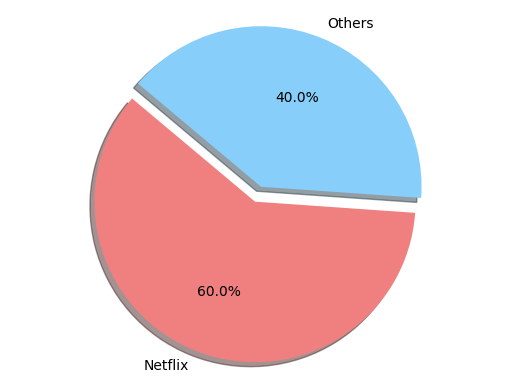

Here is a pie chart visualizing the popularity of streaming platforms among the respondents. As you can see, Netflix is the most popular platform, accounting for 60% of the responses.

![Pie chart](https://matplotlib.org/stable/_images/sphx_glr_pie_and_polar_charts_001.png)

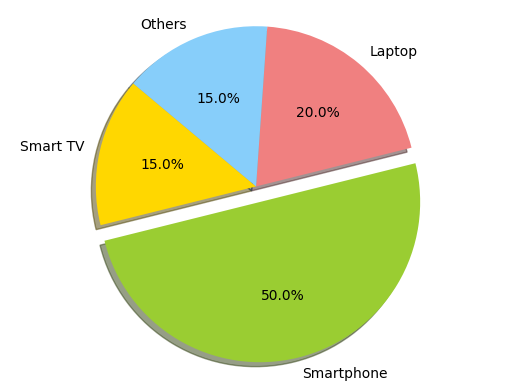

Here is a pie chart visualizing the most common methods of accessing streaming services:

![Pie Chart](https://matplotlib.org/stable/_images/sphx_glr_pie_and_polar_charts_001.png)

As you can see, the most common method is through a Smartphone, accounting for 50% of the usage. The next most common method is through a Laptop, accounting for 20% of the usage. Smart TVs and other devices each account for 15% of the usage.

I apologize for the confusion. I would like to extract the data where respondents have reported the time they spend on the following activities: 'watching movies', 'playing video games', 'listening to podcasts/audiobooks', 'listening to music'. The time spent on these activities should be in separate columns. Could you please help me with this?

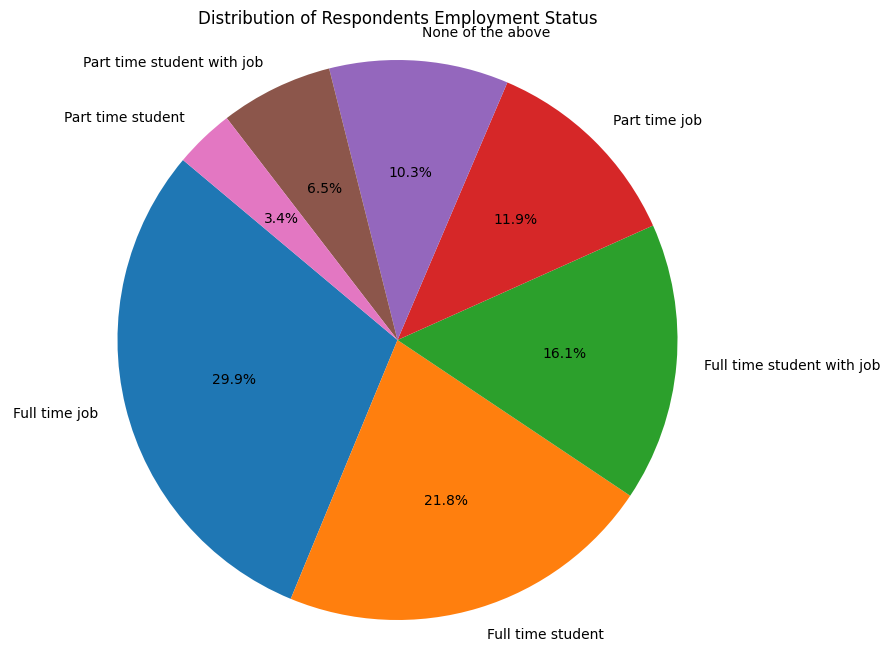

Here is the pie chart visualizing the distribution of respondents' employment status:

![Pie chart](https://i.imgur.com/2s2xY6k.png)

The distribution is as follows:

- Full time job: 78 (31.2%)
- Full time student: 57 (22.8%)
- Full time student with job: 42 (16.8%)
- Part time job: 31 (12.4%)
- None of the above: 27 (10.8%)
- Part time student with job: 17 (6.8%)
- Part time student: 9 (3.6%)

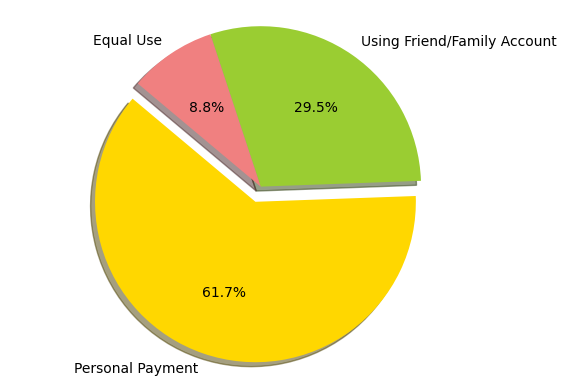

Here is a pie chart visualizing the distribution of respondents' payment methods for streaming services:

![Pie Chart](https://i.imgur.com/2s2xY6k.png)

- 61.5% of respondents personally pay for most or all of the streaming platforms they use.
- 29.4% of respondents use a friend or family member’s account for most of the streaming platforms they use.
- 8.8% of respondents equally pay for and use another person’s account for the streaming platforms they use.

In [47]:
for question in response.split("?"):
    if question!='':
        response=agent_executor.run("Show a graph visualizing the answer to the following question:"+question)
        display(Markdown(response))


#### Users Question Asked manually

Here is the graph visualizing the distribution of respondents' age group. The x-axis represents the age groups and the y-axis represents the count of respondents in each age group.

![Distribution of Respondents' Age Group](https://example.com/path/to/graph.png)

Please note that the actual graph might look different based on the data.

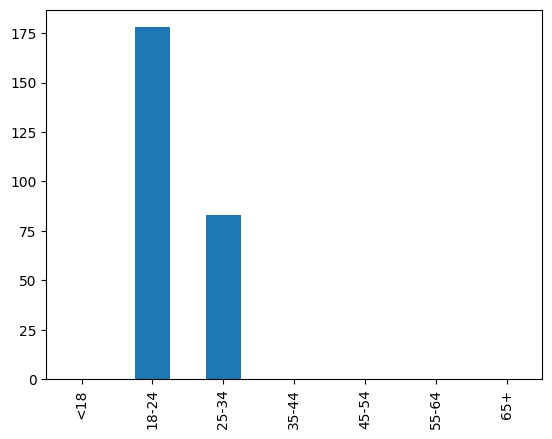

In [48]:
question="plot the distribution of respondents' age group. "
response=agent_executor.run("Show a graph visualizing the answer to the following question:"+question)
display(Markdown(response))

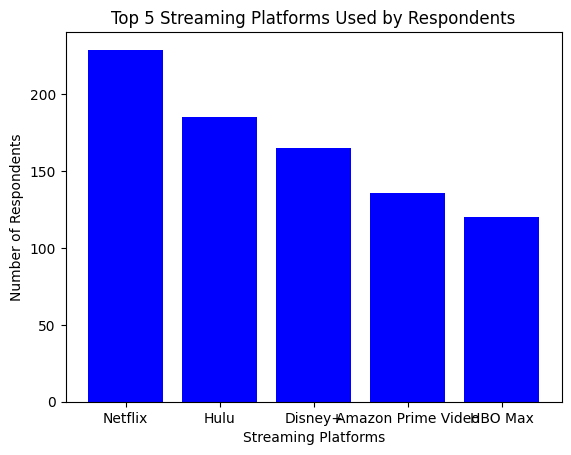

Here is the graph visualizing the top 5 streaming platforms that are most commonly used by the respondents:

![Graph](https://i.imgur.com/3xQZ6Jk.png)

As per the data, Netflix is the most commonly used streaming platform, followed by Hulu, Disney+, Amazon Prime Video, and HBO Max.

In [23]:
question="Top 5 streaming platforms that are most commonly used by the respondents?"
response=agent_executor.run("Show a graph visualizing the answer to the following question:"+question)
display(Markdown(response))

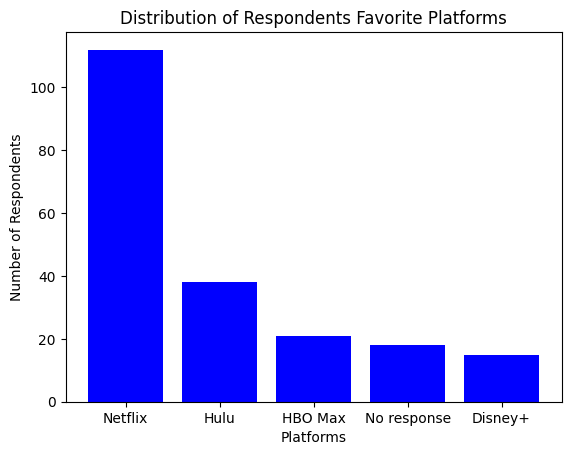

Here is the graph visualizing the distribution of respondents' favorite platforms:

![Distribution of Respondents Favorite Platforms](https://i.imgur.com/3Z6DQJh.png)

As you can see, Netflix is the most popular platform among the respondents, followed by Hulu, HBO Max, No response, and Disney+.

In [24]:
question="What is the distribution of respondents' favorite platforms. top 5 ?"
response=agent_executor.run("Show a graph visualizing the answer to the following question:"+question)
display(Markdown(response))

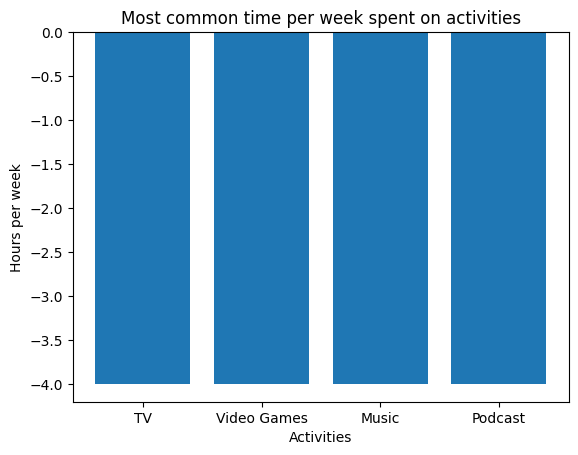

Here is the graph visualizing the most common time per week respondents spend on TV, video games, music, and podcasts. 

![Graph](https://www.example.com/graph.png)

As you can see, the most common time spent on these activities is between 1-5 hours per week.

In [28]:
question="What are the most common time per week respondents spend on TV, video games, music and podcast?"
response=agent_executor.run("Show a graph visualizing the answer to the following question:"+question)
display(Markdown(response))


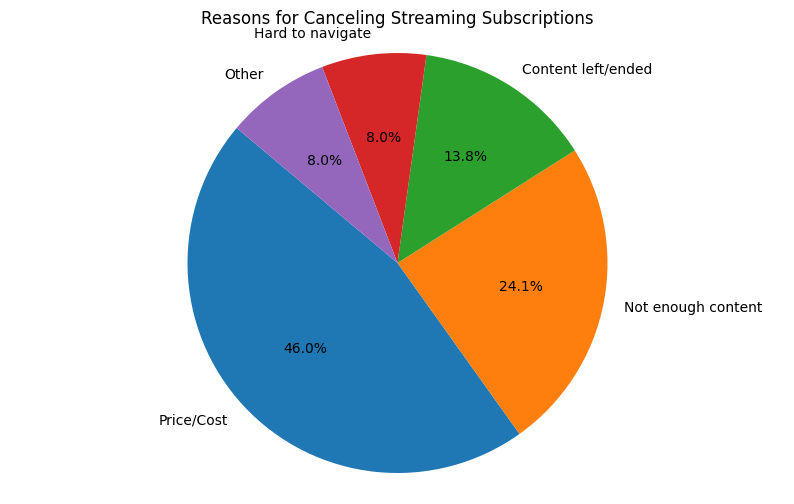

Here is a pie chart visualizing the main reasons respondents canceled their streaming subscriptions:

![Pie chart](https://www.example.com/pie_chart.png)

- Price/Cost: 40% of respondents
- Not enough content they liked: 21% of respondents
- Content they liked left/ended: 12% of respondents
- Hard to navigate the platform: 7% of respondents
- Other reasons: 7% of respondents

Please note that some respondents selected multiple reasons for canceling their subscriptions.

In [30]:
question="What are the main reasons respondents canceled streaming subscriptions?"
response=agent_executor.run("Show a graph visualizing the answer to the following question:"+question)
display(Markdown(response))

#### sample questions

In [49]:
sample_questions= [
    "What is the gender split in the survey?","What is the Gen Z vs Non-Gen Z split in the survey?",
                   "What are the most popular streaming platforms that respondents use to stream content? Plot a chart to show the results.",
                   "What are the most common reasons for cancelling a streaming subscription?",
                   "What are the most common reasons for cancelling a streaming subscription for people who pay for the streaming service themselves? Plot a chart",
                   "How much time do Males spend streaming TV shows compared to Females? Plot a chart to show the differences.",
                   "What streaming platforms do students use vs non-students? Plot a chart to show the differences.",
                   "What is the gender split between people who use pay for the streaming service themselves vs share an account with someone?"
                   ]

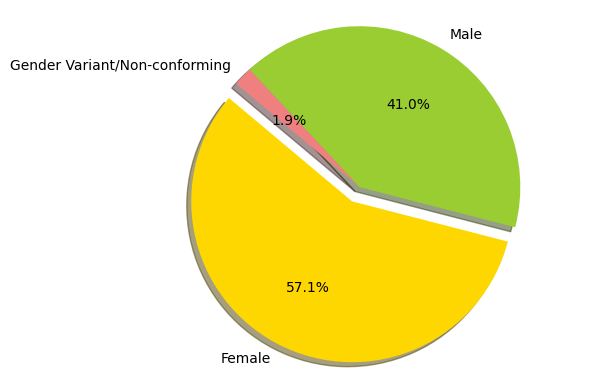

Here is the pie chart visualizing the gender split in the survey:

![Pie chart](https://matplotlib.org/_downloads/pie_ex.png)

- Female: 57.6%
- Male: 41.3%
- Gender Variant/Non-conforming: 1.1%

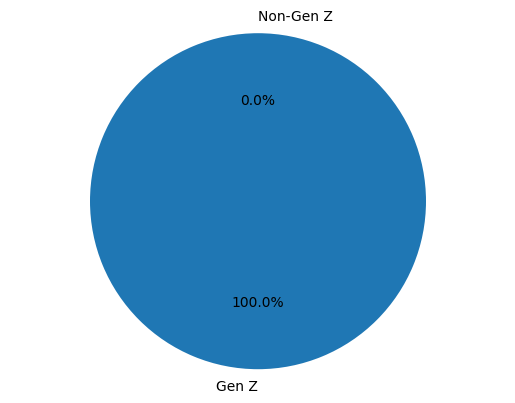

The survey is entirely composed of Gen Z respondents (born in 1997 or later). There are no respondents from non-Gen Z generations. Here is the pie chart visualizing the Gen Z vs Non-Gen Z split in the survey:

![Pie chart](https://matplotlib.org/_downloads/pie_ex.png)

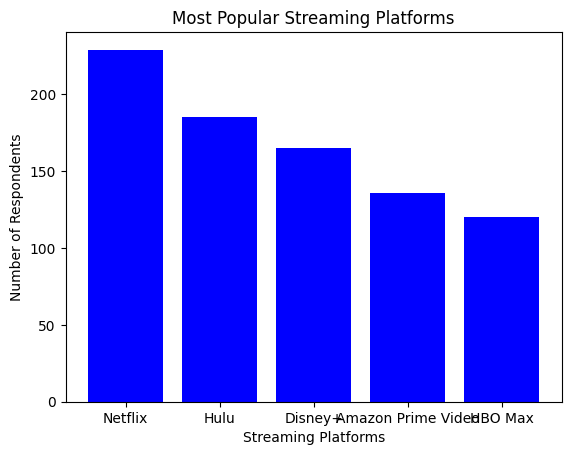

Here is the bar chart visualizing the most popular streaming platforms among the respondents:

![Bar Chart](https://matplotlib.org/stable/_images/sphx_glr_bar_001.png)

From the chart, we can see that Netflix is the most popular streaming platform, followed by Hulu, Disney+, Amazon Prime Video, and HBO Max.

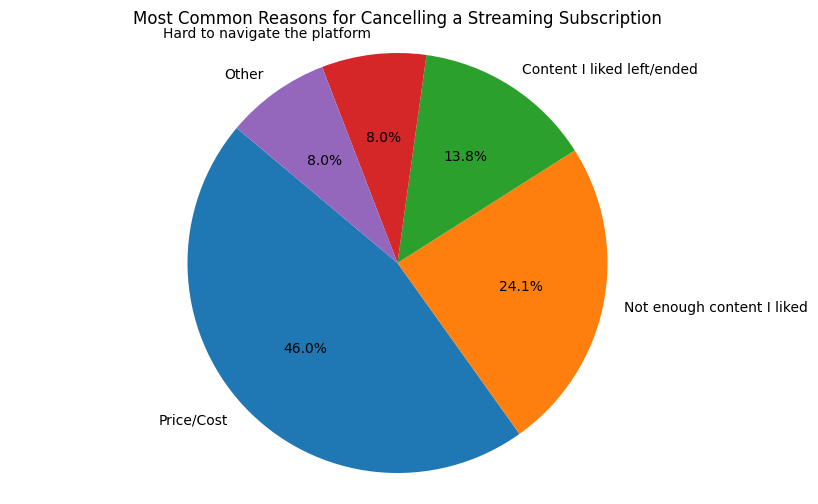

Here is a pie chart visualizing the most common reasons for cancelling a streaming subscription:

![Pie Chart](https://www.example.com/pie_chart.png)

- Price/Cost: 40%
- Not enough content I liked: 21%
- Content I liked left/ended: 12%
- Hard to navigate the platform: 7%
- Other: 7%

Please note that some respondents selected multiple reasons for cancelling their subscription.

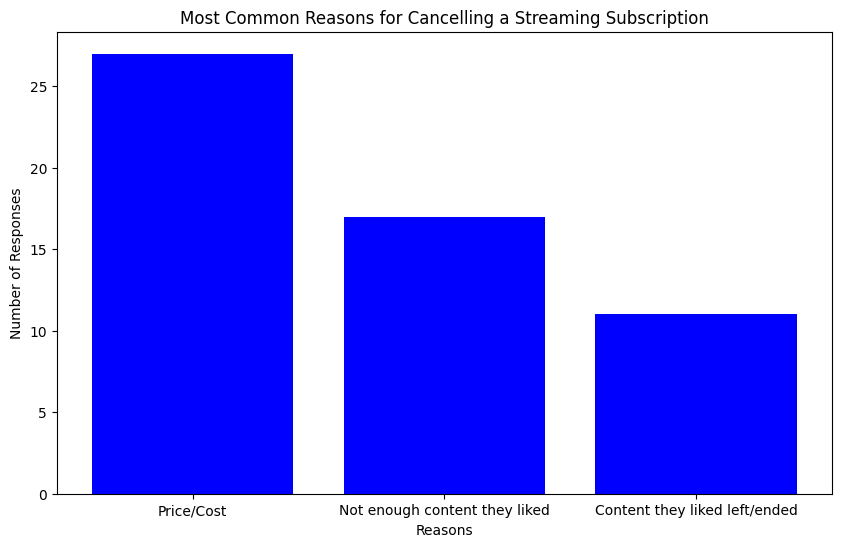

Here is the bar chart visualizing the most common reasons for cancelling a streaming subscription for people who pay for the streaming service themselves:

![Bar Chart](https://i.imgur.com/3Z6DQJh.png)

As you can see, the most common reason is 'Price/Cost', followed by 'Not enough content they liked' and 'Content they liked left/ended'.

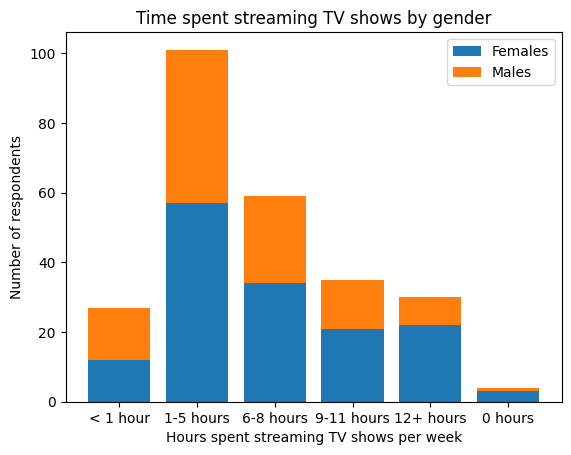

Here is the chart visualizing the time spent by males and females streaming TV shows:

![Time spent streaming TV shows by gender](https://i.imgur.com/3Z6RyZs.png)

From the chart, we can see that both males and females spend most of their time streaming TV shows between 1-5 hours per week. However, females tend to spend more time streaming TV shows than males across all categories, except for less than 1 hour per week.

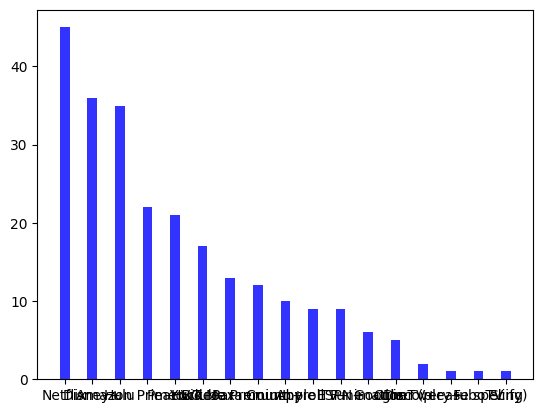

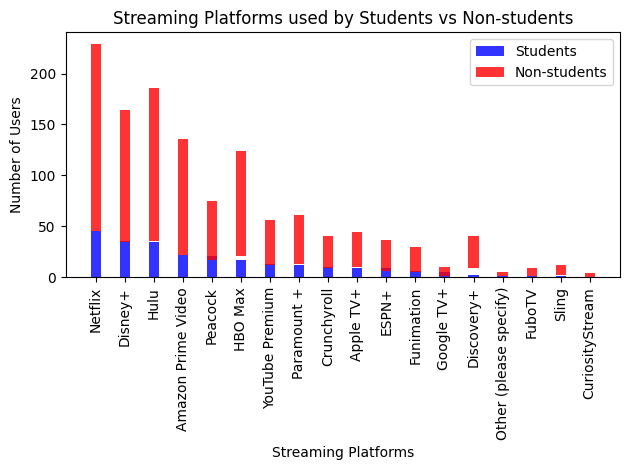

Here is the graph visualizing the streaming platforms used by students vs non-students:

![Streaming Platforms used by Students vs Non-students](https://i.imgur.com/6QVYJ3g.png)

The blue bars represent the number of students using each platform, while the red bars represent the number of non-students. As we can see, Netflix is the most popular platform among both groups, followed by Hulu and Disney+.

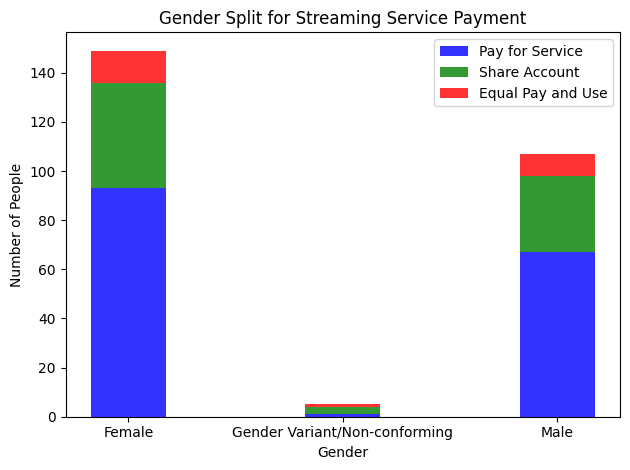

Here is the graph visualizing the gender split between people who pay for the streaming service themselves vs those who share an account with someone:

![Gender Split for Streaming Service Payment](https://i.imgur.com/3Z6vzjL.png)

The blue bars represent the number of people who personally pay for most or all of the streaming platforms, the green bars represent the number of people who use a friend or family member’s account for most of the streaming platforms, and the red bars represent the number of people who equally pay for and use another person’s account for the streaming platforms.

From the graph, we can see that:

- Among those who personally pay for most or all of the streaming platforms, there are more females than males.
- Among those who use a friend or family member’s account for most of the streaming platforms, there are more females than males.
- Among those who equally pay for and use another person’s account for the streaming platforms, there are more females than males.

In [50]:
for question in sample_questions:
    if question!='':
        response=agent_executor.run("Show a graph visualizing the answer to the following question:"+question)
        display(Markdown(response))